In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from pmdarima import auto_arima
import os
import sys
from tqdm import tqdm

sys.path.append(os.path.join(os.getcwd(), "EDA"))
from EDA import *

In [4]:
# parameters
DATA_PATH = '../../data/high_10m.parquet'
NUM_LAGS = 10
NUM_STOCKS = 10
TRAIN_WINDOW = 50
OUTPUT_PATH = '../../data/processed_high_10m_subset.parquet'
SEED = 42
SHRINKAGE_LIST = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

df = pd.read_parquet(DATA_PATH)
df.head()

df = df[df['RETURN_NoOVERNIGHT'] != 0]
df


,DATE,SYMBOL,TIME,ALL_EX,MID_OPEN,SUM_DELTA,RETURN_NoOVERNIGHT,LOG_RETURN_NoOVERNIGHT,RETURN_SiOVERNIGHT,LOG_RETURN_SiOVERNIGHT
1,2021-12-01,A,09:40:00,PBTJVDZUYKNHCXM,150.490,0.473357,-0.011170,-0.011233,-0.011170,-0.011233
2,2021-12-01,A,09:50:00,KDPBTJVNZUCXYH,151.475,-10.867709,0.006545,0.006524,0.006545,0.006524
3,2021-12-01,A,10:00:00,DABTJNKYVPZUXCH,150.510,-0.125414,-0.006371,-0.006391,-0.006371,-0.006391
4,2021-12-01,A,10:10:00,DVJTPNKUZYACBXHM,151.960,-1.274648,0.009634,0.009588,0.009634,0.009588
5,2021-12-01,A,10:20:00,DPCNZUKYTJVHBMAX,151.790,-2.211760,-0.001119,-0.001119,-0.001119,-0.001119
...,...,...,...,...,...,...,...,...,...,...
6156352,2021-12-31,ZYXI,14:50:00,VDKJQUPXZ,10.125,-0.027897,0.005462,0.005447,0.005462,0.005447
6156353,2021-12-31,ZYXI,15:00:00,DVJPQUZN,10.055,-0.050725,-0.006914,-0.006938,-0.006914,-0.006938
6156354,2021-12-31,ZYXI,15:10:00,DQKJVUZ,10.040,-0.032836,-0.001492,-0.001493,-0.001492,-0.001493
6156356,2021-12-31,ZYXI,15:30:00,UKVQZPNDJ,10.010,-0.124826,-0.002988,-0.002993,-0.002988,-0.002993


#### 1. Comparison of linear returns vs log returns
- Description
- Plot the density

Description of
RETURN_NoOVERNIGHT
count    4.956055e+06
mean    -7.984415e-05
std      7.275080e-03
min     -3.551797e-01
25%     -1.791604e-03
50%      3.761661e-05
75%      1.697473e-03
max      7.381823e-01
Name: RETURN_NoOVERNIGHT, dtype: float64:
Skew: 1.391390286700335
Kurtosis: 198.65418550148098
Description of
LOG_RETURN_NoOVERNIGHT
count    4.956055e+06
mean    -1.062595e-04
std      7.269434e-03
min     -4.387836e-01
25%     -1.793210e-03
50%      3.761590e-05
75%      1.696034e-03
max      5.528399e-01
Name: LOG_RETURN_NoOVERNIGHT, dtype: float64:
Skew: -0.44222061427871723
Kurtosis: 154.3645631906183


KeyboardInterrupt: 

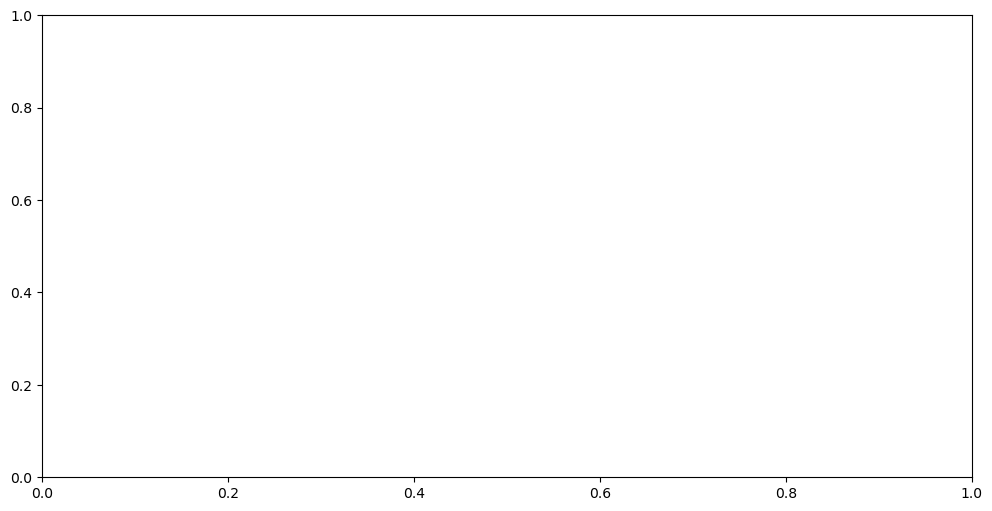

In [5]:
describe_series(df["RETURN_NoOVERNIGHT"])
describe_series(df["LOG_RETURN_NoOVERNIGHT"])
plot_density_logvslin(df["RETURN_NoOVERNIGHT"], df["LOG_RETURN_NoOVERNIGHT"])

Both aggregated linear and log returns look normal distributed, with log returns showing the additional benefit of smoothing out the extreme tails.
From this moment foward, we consider in our analysis only log returns. 
#### 2. Outliners analysis

In [ ]:
plot_boxplot(df["LOG_RETURN_NoOVERNIGHT"])
plot_violin(df["LOG_RETURN_NoOVERNIGHT"])
plot_ecdf(df["LOG_RETURN_NoOVERNIGHT"])
plot_qq(df["LOG_RETURN_NoOVERNIGHT"])

In [ ]:
# Winsorized Dataframe
winsorized_df = select_winsorized(df, column= 'LOG_RETURN_NoOVERNIGHT', lower_percentile=0.01, upper_percentile= 0.99)
describe_series(winsorized_df["LOG_RETURN_NoOVERNIGHT"])
plot_histogram_distribution(winsorized_df["LOG_RETURN_NoOVERNIGHT"], n_bins=500, left_limit = -0.01, right_limit = 0.01)
plot_boxplot(winsorized_df["LOG_RETURN_NoOVERNIGHT"])
plot_violin(winsorized_df["LOG_RETURN_NoOVERNIGHT"])
plot_ecdf(winsorized_df["LOG_RETURN_NoOVERNIGHT"])
plot_qq(winsorized_df["LOG_RETURN_NoOVERNIGHT"])

#### 3. Correlation and dependence analysis

In [ ]:
winsorized_df['DATETIME'] = pd.to_datetime(winsorized_df['DATE'].astype(str) + ' ' + df['TIME'].astype(str))

returns_pivot = winsorized_df.pivot_table(index='DATETIME', columns='SYMBOL', values='LOG_RETURN_NoOVERNIGHT', aggfunc='mean')
distribution_correlation(returns_pivot)

#TODO: not sure what the y axis 


In [ ]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Check stationarity, autocorrelation, and partial autocorrelation in automatic way, choosing the best ARIMA parameters
# ARIMA model is used fir each stock symbol and the results are stored in a DataFrame

results = []

for symbol, group in winsorized_df.groupby('SYMBOL'):
    group = group.sort_index()
    series = group['LOG_RETURN_NoOVERNIGHT'].dropna()

    if len(series) < 20:
        continue

    # Create train/test split
    split = int(len(series) * 0.9)
    train, test = series[:split], series[split:]

    try:
        # Workaround: convert series to array but preserve date index externally
        model = auto_arima(train.values, seasonal=False, suppress_warnings=True, stepwise=True)

        forecast = model.predict(n_periods=len(test))

        mse = mean_squared_error(test.values, forecast)

        results.append({
            'symbol': symbol,
            'order': model.order,
            'aic': model.aic(),
            'bic': model.bic(),
            'mse': mse,
            'train_len': len(train),
            'test_len': len(test)
        })

    except Exception as e:
        print(f"{symbol}: ARIMA failed - {e}")

results_df = pd.DataFrame(results)
print(results_df.describe())


In [ ]:
import pandas as pd
from arch import arch_model
from tqdm import tqdm

def add_garch_volatility(df, return_col='LOG_RETURN_NoOVERNIGHT'):
    df = df.copy()
    df['GARCH_VOL'] = None  # Placeholder for volatility

    # Group by stock symbol
    grouped = df.groupby('SYMBOL')

    all_vols = []

    for symbol, group in tqdm(grouped, desc='Fitting GARCH'):
        group = group.sort_index()
        returns = group[return_col].dropna()

        # Fit only if enough data
        if len(returns) < 50:
            continue

        try:
            # Fit GARCH(1,1)
            model = arch_model(returns, vol='GARCH', p=1, q=1)
            result = model.fit(disp='off')

            # Extract conditional volatility
            vol = result.conditional_volatility
            vol_df = vol.to_frame(name='GARCH_VOL')
            vol_df['SYMBOL'] = symbol
            vol_df['DATETIME'] = vol_df.index

            all_vols.append(vol_df)

        except Exception as e:
            print(f"GARCH failed for {symbol}: {e}")

    # Merge GARCH volatility back to main df
    if all_vols:
        garch_df = pd.concat(all_vols)
        df = df.merge(garch_df, on=['SYMBOL', 'DATETIME'], how='left', suffixes=('', '_GARCH'))

    return df

# Your original returns DataFrame (with DATETIME index or column)
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

# Call the function
df_with_vol = add_garch_volatility(df, return_col='LOG_RETURN_NoOVERNIGHT')

